In [1]:
import os

# Set working directory to notebook's location
os.chdir(os.path.dirname(os.path.abspath("__file__")))  # This works in scripts
# OR if in notebook
os.chdir(os.getcwd())  # You can hardcode path if needed, e.g. os.chdir("/home/user/project")

print("Working directory:", os.getcwd())


Working directory: d:\Anuj\Woxsen\IITH\retinal-oct\src


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, exposure
from skimage import img_as_float, img_as_ubyte
from skimage.util import random_noise
from skimage.color import rgb2gray

In [3]:
def denoise_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise FileNotFoundError(f"❌ Could not read image at: {image_path}")

    img = img_as_float(img)

    denoised = restoration.denoise_nl_means(
        img, h=0.8, fast_mode=True,
        patch_size=5, patch_distance=3,
        channel_axis=None
    )
    return img, denoised


In [4]:
#def enhance_contrast(img):
#    enhanced = exposure.equalize_adapthist(img, clip_limit=0.03)
#    return enhanced

In [5]:
def detect_edges(img):
    img_uint8 = img_as_ubyte(img)
    edges = cv2.Canny(img_uint8, threshold1=30, threshold2=100)
    return edges

In [6]:
def multipoint_layer_edges(edge_map, top_k=3):
    h, w = edge_map.shape
    edge_points = []

    for col in range(w):
        points = np.where(edge_map[:, col] != 0)[0]
        if len(points) >= top_k:
            edge_points.append(points[:top_k])  # Take top-k points per column
        elif len(points) > 0:
            pad = [points[-1]] * (top_k - len(points))
            edge_points.append(np.concatenate([points, pad]))
        else:
            edge_points.append(np.array([0] * top_k))

    edge_points = np.array(edge_points).T  # Shape: [top_k, width]
    return edge_points

In [ ]:
def visualize_all(original, denoised, contrast, edges, layer_edges):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    axs[0, 0].imshow(original, cmap='gray')
    axs[0, 0].set_title("Original OCT")

    axs[0, 1].imshow(denoised, cmap='gray')
    axs[0, 1].set_title("Denoised Image")

    axs[0, 2].imshow(contrast, cmap='gray')
    axs[0, 2].set_title("Contrast Enhanced")

    axs[1, 0].imshow(edges, cmap='gray')
    axs[1, 0].set_title("Canny Edges")

    # Overlay multipoint edges
    vis_img = np.copy(contrast)
    for layer in layer_edges:
        for x, y in enumerate(layer):
            if y < vis_img.shape[0]:
                vis_img[y, x] = 1.0  # Bright line at edge

    axs[1, 1].imshow(vis_img, cmap='gray')
    axs[1, 1].set_title("Multi-point Detected Edges")

    axs[1, 2].axis('off')
    axs[1, 2].text(0.1, 0.5, "Each row = Top edge in a column\nCan help track horizontal retinal layers", fontsize=14)

    for ax in axs.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 🚀 Run the full pipeline
image_path = "../data/test/CNV/CNV-5536678-2.jpeg"  # Replace with your image
original, denoised = denoise_image(image_path)
#contrast = enhance_contrast(denoised)
#edges = detect_edges(contrast)
layer_edges = multipoint_layer_edges(edges, top_k=3)
#visualize_all(original, denoised, contrast, edges, layer_edges)
visualize_all(original, denoised, layer_edges)

NameError: name 'edges' is not defined

CBD denoising

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# DnCNN model definition
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(channels, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out

def load_dncnn_model(model_path, device):
    model = torch.load(model_path, map_location=device, weights_only=False)  # ← important!
    model.eval()
    return model.to(device)

def denoise_dncnn(image_path, model_path="model.pth", device="cuda" if torch.cuda.is_available() else "cpu"):
    model = load_dncnn_model(model_path, device)

    img = Image.open(image_path).convert('L')
    transform = transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)

    output_np = output.squeeze(0).squeeze(0).cpu().numpy()
    output_np = np.clip(output_np, 0, 1)

    return np.array(img), (output_np * 255).astype(np.uint8)



c:\Users\anujm\anaconda3\envs\iith\Lib\site-packages\torch\serialization.py:1589: UserWarning: Couldn't retrieve source code for container of type DnCNN. It won't be checked for correctness upon loading.
  warnings.warn(
c:\Users\anujm\anaconda3\envs\iith\Lib\site-packages\torch\serialization.py:1634: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\Users\anujm\anaconda3\envs\iith\Lib\site-packages\torch\serialization.py:1634: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning

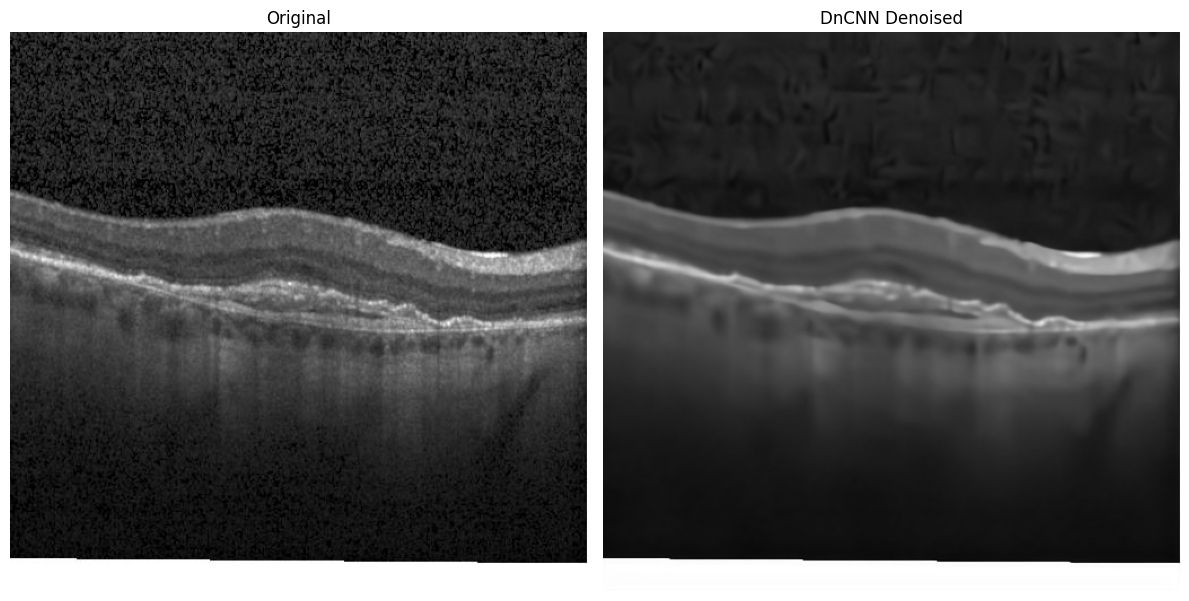

In [ ]:
image_path = "../data/test/CNV/CNV-81630-1.jpeg"
model_path = "../model.pth"  # Full model, not state_dict


try:
    original, denoised = denoise_dncnn(image_path, model_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(denoised, cmap='gray')
    plt.title("DnCNN Denoised")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ File not found: {image_path}")
except Exception as e:
    print(f"🔥 Error: {e}")